In [1]:
import confluent_kafka
import time
from pykafka import KafkaClient
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
msg_count = 1000
msg_size = 100
iteration=30
msg_payload = ('kafkatest' * 20).encode()[:msg_size]
print(msg_payload)
print(len(msg_payload))
topic = 'confluent-kafka-topic'
bootstrap_servers = 'localhost:9092'

producer_timings = {}
producer_messages={}

b'kafkatestkafkatestkafkatestkafkatestkafkatestkafkatestkafkatestkafkatestkafkatestkafkatestkafkatestk'
100


In [3]:
def confluent_kafka_producer_performance(msg_count):
    
    topic = 'confluent-kafka-topic'
    conf = {'bootstrap.servers': bootstrap_servers}
    producer = confluent_kafka.Producer(**conf)
    messages_to_retry = 0

    producer_start = time.time()
    for i in range(msg_count):
        try:
            producer.produce(topic, value=msg_payload)
            #producer.poll(0)
        except BufferError as e:
            producer.flush()
            messages_to_retry += 1

    #retry messages that over filled the local buffer
    for i in range(messages_to_retry):
        producer.poll(0)
        try:
            producer.produce(topic, value=msg_payload)
        except BufferError as e:
            producer.poll(0)
            producer.produce(topic, value=msg_payload)

    producer.flush()
            
    return time.time() - producer_start


def calculate_thoughput(timing, n_messages=msg_count, msg_size=100):
    print("Processed {0} messsages in {1:.2f} seconds".format(n_messages, timing))
    print("{0:.2f} MB/s".format((msg_size * n_messages) / timing / (1024*1024)))
    print("{0:.2f} Msgs/s".format(n_messages / timing))


In [4]:
for i in range(iteration):
    time_t=confluent_kafka_producer_performance(msg_count)
    producer_timings[msg_count] = time_t
    producer_messages[msg_count]=msg_count/time_t
    #calculate_thoughput(producer_timings[msg_count])
    msg_count=msg_count + 1000

In [5]:
'''
print(msg_count)
for item in producer_timings:
    print (item)
    print(producer_timings[item])
    '''

'\nprint(msg_count)\nfor item in producer_timings:\n    print (item)\n    print(producer_timings[item])\n    '

In [6]:

#print(msg_count)
total_num_mes=0
for item in producer_messages:
    total_num_mes=producer_messages[item] + total_num_mes
avg=total_num_mes/iteration    
print("After Taking avergae number of messages written per second ::",avg)


After Taking avergae number of messages written per second :: 58045.27802907148


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f78a5855080>],
      dtype=object)

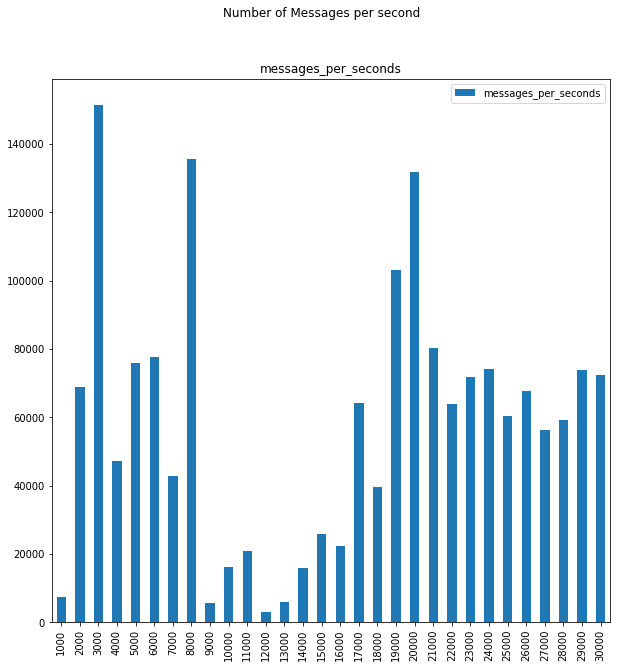

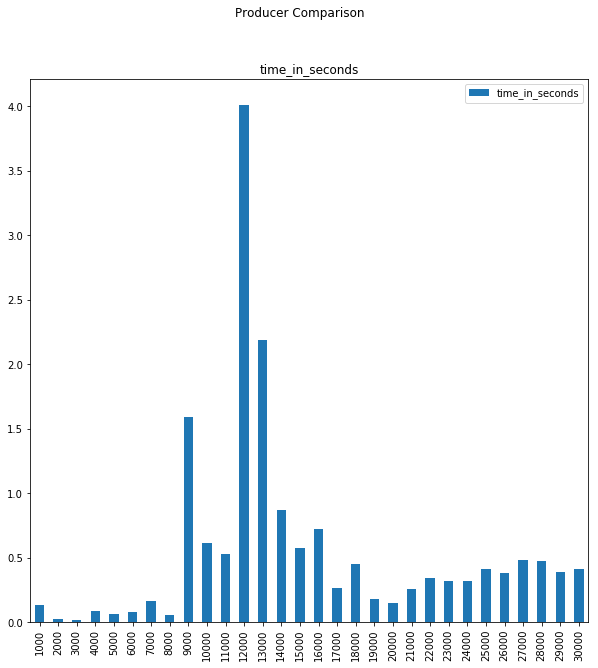

In [7]:
producer_df = pd.DataFrame.from_dict(producer_timings, orient='index').rename(columns={0: 'time_in_seconds'})
producer_df1 = pd.DataFrame.from_dict(producer_messages, orient='index').rename(columns={0: 'messages_per_seconds'})

producer_df1.sort_index(inplace=True)
producer_df1
producer_df1.plot(kind='bar', subplots=True, figsize=(10, 10), title="Number of Messages per second")

producer_df.sort_index(inplace=True)
producer_df
producer_df.plot(kind='bar', subplots=True, figsize=(10, 10), title="Producer Comparison")
